# Variational GP on an CMB Image
## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import sys
sys.path.append("..")
from vgp.vgp_sqExp import vgp_sqExp
from datetime import datetime
import math

## Load file

In [2]:
im0 = pd.read_csv("data/comm18_cut_masked_id0.txt", sep=" ", header=None)
N = int(math.sqrt(im0.shape[0]))
im0.head()

,0,1,2
0,0.0,0.0,266.0
1,0.0,1.0,256.0
2,0.0,2.0,203.0
3,0.0,3.0,106.0
4,0.0,4.0,136.0


## Split data into training and test sets

In [3]:
from sklearn.model_selection import train_test_split
X = im0[[0, 1]].to_numpy()
y = im0[2].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)
y_train = y_train.reshape((y_train.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

## Visualize image

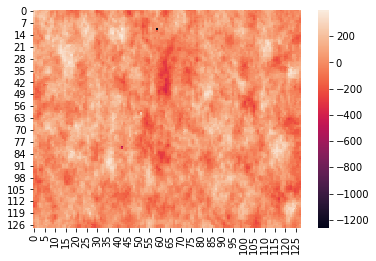

In [4]:
sns.heatmap(y.reshape(N,N))

## RMSE on test set based on prediction by mean
Can be treated as the benchmark which can be compared to the RMSE based on GP.

In [5]:
m = y_train.mean()
np.linalg.norm(y_test - m)/math.sqrt(y_test.shape[0])

103.15580272799336

## Test Variational GP with different numbers of inducing inputs

### Method for generating equally spaced inducing inputs

In [6]:
def inducingInputsGenerator(X, sqrtNumInduce):
    p = np.linspace(0, 1, sqrtNumInduce+2)[1:sqrtNumInduce+1]
    quantiles = np.quantile(X, p, axis=0)
    X_inducing = np.zeros((sqrtNumInduce*sqrtNumInduce, 2))
    for i in range(sqrtNumInduce):
        for j in range(sqrtNumInduce):
            index_num = sqrtNumInduce*i + j
            X_inducing[index_num, 0] = quantiles[i, 0]
            X_inducing[index_num, 1] = quantiles[j, 1]
    
    return X_inducing

### Train the model with different numbers of inducing inputs and compute test RMSE's

In [7]:
sigmaSqf = 0.0001
lscale = 0.01
varErr = 0.00001

errs = []
for sqrtNumInduce in range(1, 21):
    X_inducing = inducingInputsGenerator(X, sqrtNumInduce)
            
    gpImage = vgp_sqExp(X_train,
                        y_train,
                        X_inducing,
                        sigmaSqf,
                        lscale,
                        varErr)
    gpImage.train()
    print("sqrt(m)="+str(sqrtNumInduce), end=": ")
    pred = gpImage.predictMean(X_test, 
                          y_test, 
                          True)
    errs.append(np.linalg.norm(pred-y_test)/math.sqrt(pred.shape[0]))

sqrt(m)=1: Test RMSE=103.16892363708683.
sqrt(m)=2: Test RMSE=102.70737263800238.
sqrt(m)=3: Test RMSE=100.32708426071785.
sqrt(m)=4: Test RMSE=101.78105268425881.
sqrt(m)=5: Test RMSE=97.34913420463626.
sqrt(m)=6: Test RMSE=96.9118873250435.
sqrt(m)=7: Test RMSE=94.36299172201673.
sqrt(m)=8: Test RMSE=90.14317411229177.
sqrt(m)=9: Test RMSE=85.94823852311839.
sqrt(m)=10: Test RMSE=86.03216910200436.
sqrt(m)=11: Test RMSE=82.36477607396863.
sqrt(m)=12: Test RMSE=80.07391126713443.
sqrt(m)=13: Test RMSE=77.22209493492893.
sqrt(m)=14: Test RMSE=74.83243905161278.
sqrt(m)=15: Test RMSE=73.87081515218419.
sqrt(m)=16: Test RMSE=73.1761861871656.
sqrt(m)=17: Test RMSE=70.82167203156912.
sqrt(m)=18: Test RMSE=69.14332510998005.
sqrt(m)=19: Test RMSE=66.1785995695283.
sqrt(m)=20: Test RMSE=64.231309964033.


Below is the plot of test RMSE vs sqrt of the num of inducing inputs

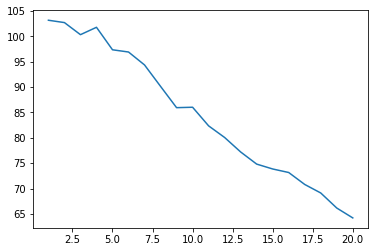

In [9]:
sns.lineplot(x=list(range(1,21)), y=errs)

## Test the method (with 32^2=1024~1000 inducing inputs)
Inducing inputs are taken to be equally spaced points in the grid.

### Training

In [10]:
X_inducing = inducingInputsGenerator(X, 32)
sigmaSqf = 0.0001
lscale = 0.01
varErr = 0.00001

gpImage = vgp_sqExp(X_train,
                    y_train,
                    X_inducing,
                    sigmaSqf,
                    lscale,
                    varErr)
gpImage.train(printElapsedTime=True)

Elapsed Time (in Seconds): 155


### Make predictions on the test set and print RMSE

In [11]:
pred = gpImage.predictMean(X_test, y_test, True)

Test RMSE=49.16622808291989.


### Reproduce image based on the mean prediction at each point in the grid

In [12]:
pred_image = gpImage.predictMean(X, y)

### Visualize the reproduced image

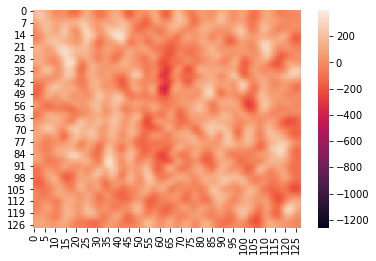

In [13]:
sns.heatmap(pred_image.reshape(N,N), vmin=-1260, vmax=398)

## Reproduce image based on the trained model with a very small length scale

In [14]:
lscale = 0.000000001

gpImage = vgp_sqExp(X_train,
                    y_train,
                    X_inducing,
                    sigmaSqf,
                    lscale,
                    varErr)
gpImage.train(printElapsedTime=True)

Elapsed Time (in Seconds): 171


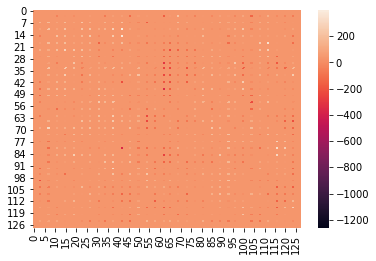

In [15]:
pred_image = gpImage.predictMean(X, y)
sns.heatmap(pred_image.reshape(N,N), vmin=-1260, vmax=398)